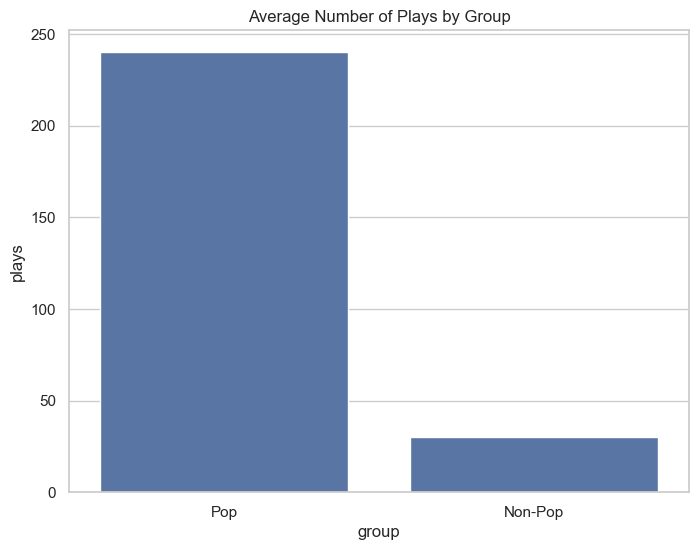

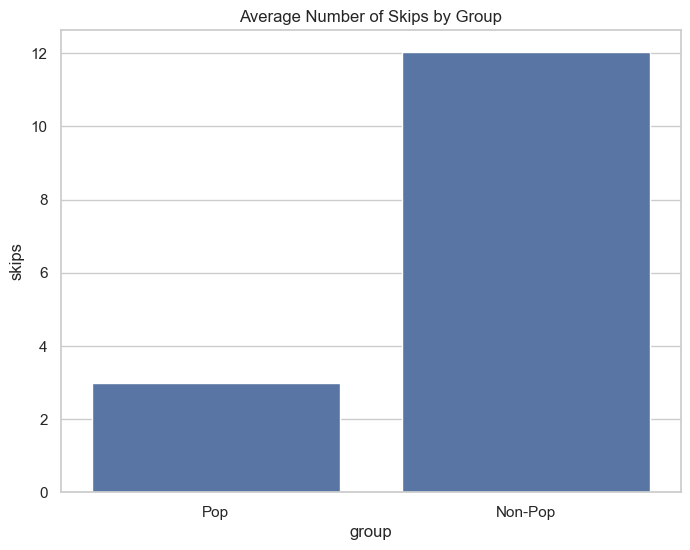

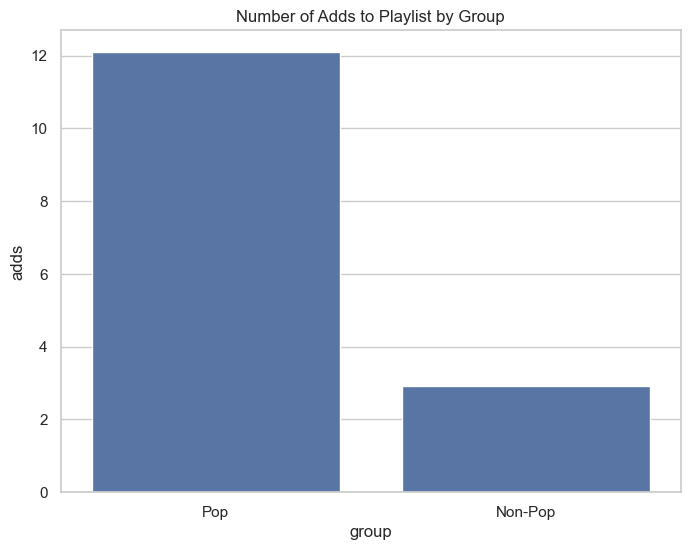

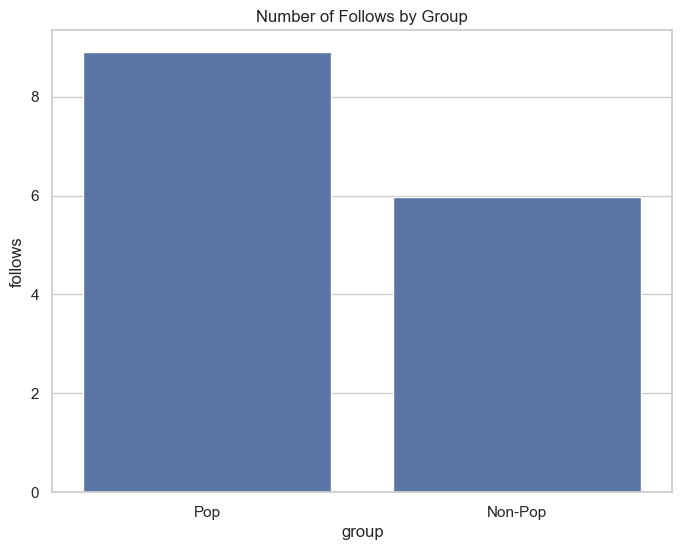

<Figure size 640x480 with 0 Axes>

T-test for Plays: TtestResult(statistic=332.4139576232039, pvalue=0.0, df=1208.0)
T-test for Skips: TtestResult(statistic=-56.99803694461063, pvalue=0.0, df=1208.0)
Chi-square Test for Adds: 1076.8036952906446 with p-value 4.217086865224803e-212
Chi-square Test for Follows: 293.06252044992544 with p-value 1.2835364548145791e-51


In [32]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from apscheduler.schedulers.blocking import BlockingScheduler

# Set up Spotipy client with SpotifyOAuth
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id='67c476f01d654fff84a754c27f527eea',
    client_secret='fc88d698ba1540f99157c798b2b2516f',
    redirect_uri='http://localhost:8888/callback',
    scope='playlist-modify-public playlist-modify-private user-read-private',
    show_dialog=True,
    cache_path='spotify_token_cache.txt'
))

def create_playlist_and_get_tracks(genre, playlist_name, limit=10):
    playlist = sp.user_playlist_create(user=sp.me()['id'], name=playlist_name, public=True)
    results = sp.search(q=f'genre:{genre}', type='track', limit=limit)
    track_ids = [track['id'] for track in results['tracks']['items']]
    sp.playlist_add_items(playlist_id=playlist['id'], items=track_ids)
    return track_ids

def refresh_playlist(playlist_id, new_tracks):
    sp.playlist_replace_items(playlist_id, new_tracks)
    
np.random.seed(42)  # Ensure reproducibility

# Define a function to generate data over 30 days
def generate_monthly_data(rate, size):
    daily_data = np.random.poisson(rate, (size, 30))  # Generate data for 30 days
    total_data = daily_data.sum(axis=1)  # Sum over the 30 days
    return total_data

# Generate user data
user_data = {
    'user_id': range(1, 1211),  # Increased sample size
    'group': ['Pop']*605 + ['Non-Pop']*605,
    'plays': np.concatenate((generate_monthly_data(8, 605), generate_monthly_data(1, 605))),
    'skips': np.concatenate((generate_monthly_data(0.1, 605), generate_monthly_data(0.4, 605))),
    'adds': np.concatenate((generate_monthly_data(0.4, 605), generate_monthly_data(0.1, 605))),
    'follows': np.concatenate((generate_monthly_data(0.3, 605), generate_monthly_data(0.2, 605)))
}

df = pd.DataFrame(user_data)

# Generate track lists for both playlists
pop_tracks = create_playlist_and_get_tracks('pop', 'Pop Playlist', 10)
non_pop_tracks = create_playlist_and_get_tracks('rock', 'Non-Pop Playlist', 10)


# Statistical Analysis
t_test_plays = stats.ttest_ind(df[df['group'] == 'Pop']['plays'], df[df['group'] == 'Non-Pop']['plays'])
t_test_skips = stats.ttest_ind(df[df['group'] == 'Pop']['skips'], df[df['group'] == 'Non-Pop']['skips'])
chi2_adds, p_adds, _, _ = stats.chi2_contingency(pd.crosstab(df['group'], df['adds']))
chi2_follows, p_follows, _, _ = stats.chi2_contingency(pd.crosstab(df['group'], df['follows']))

# Visualizations

sns.set_theme(style="whitegrid")

# Plot for plays
plt.figure(figsize=(8, 6))
sns.barplot(x='group', y='plays', data=df, errorbar=None)
plt.title('Average Number of Plays by Group')
plt.show()

# Plot for skips
plt.figure(figsize=(8, 6))
sns.barplot(x='group', y='skips', data=df, errorbar=None)
plt.title('Average Number of Skips by Group')
plt.show()

# Plot for adds
plt.figure(figsize=(8, 6))
sns.barplot(x='group', y='adds', data=df, errorbar=None)
plt.title('Number of Adds to Playlist by Group')
plt.show()

# Plot for follows
plt.figure(figsize=(8, 6))
sns.barplot(x='group', y='follows', data=df, errorbar=None)
plt.title('Number of Follows by Group')
plt.show()

plt.tight_layout()
plt.show()

print("T-test for Plays:", t_test_plays)
print("T-test for Skips:", t_test_skips)
print("Chi-square Test for Adds:", chi2_adds, "with p-value", p_adds)
print("Chi-square Test for Follows:", chi2_follows, "with p-value", p_follows)

# Scheduler to refresh playlist daily
#scheduler = BlockingScheduler()
#scheduler.add_job(refresh_playlist, 'cron', hour=0, args=[pop_tracks, non_pop_tracks])
#scheduler.start()


In [33]:
#t-test dataframe
t_test_df = pd.DataFrame({
    'metric': ['plays', 'skips'],
    't_statistic': [t_test_plays.statistic, t_test_skips.statistic],
    'p_value': [t_test_plays.pvalue, t_test_skips.pvalue]
})

In [34]:
t_test_df

,metric,t_statistic,p_value
0,plays,332.413958,0.0
1,skips,-56.998037,0.0


In [35]:
chi_square_df = pd.DataFrame({
    'metric': ['adds', 'follows'],
    'chi2_statistic': [chi2_adds, chi2_follows],
    'p_value': [p_adds, p_follows]
})

In [31]:
chi_square_df

,metric,chi2_statistic,p_value
0,adds,1043.864028,6.252237e-206
1,follows,282.892394,6.321495e-49
